In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
path = "/ASUS/UQ_methods/uq-method-box/experiments/experiments/exp_results/results.csv"

# "/ASUS/UQ_methods/uq-method-box/experiments/experiments/exp_results/results.csv"

df = pd.read_csv(path)

meta_cols = [
    "base_model",
    "loss_fn",
    "ensemble",
    "ensemble_members",
    "conformalized",
    "dataset_name",
    "pred_log_dir",
    "mlp_n_outputs",
    "date",
    "seed",
]

FileNotFoundError: [Errno 2] No such file or directory: '/ASUS/UQ_methods/uq-method-box/experiments/experiments/exp_results/results.csv'

# Preprocessing

In [19]:
# drop duplicate experiments and keep the one with the latest date
df = (
    df.sort_values("date")
    .drop_duplicates(meta_cols, keep="last")
    .reset_index(drop=True)
)
df["ensemble"] = df["ensemble"].fillna("None")  # should be handled when saving the dict
df = df[
    df["loss_fn"] != "quantile"
]  # discovered something wrong with quantile loss with huge nll so exclude at the moment

df["model_plot_name"] = (
    df["base_model"] + "_" + df["loss_fn"] + "_" + df["ensemble"]
)  # TODO come up with a unique model name for us to make easy plotting
df

nll      crps     check  interval   rms_cal    ma_cal  \
0        0.985650  0.373562  0.188632  2.053076  0.167476  0.145651   
1        0.962196  0.363241  0.183412  1.987732  0.164018  0.144040   
2        0.957512  0.364221  0.183923  2.015850  0.206150  0.179923   
6        0.869005  0.348042  0.175727  1.913023  0.126787  0.112460   
7        0.851506  0.345319  0.174344  1.894926  0.130445  0.117184   
8        0.832789  0.337545  0.170433  1.871873  0.146807  0.126381   
9        1.017947  0.350435  0.176830  2.037294  0.146314  0.124652   
10       1.033195  0.352471  0.177831  2.065124  0.144110  0.123678   
11       1.048715  0.356747  0.180008  2.105078  0.152840  0.127695   
15   31951.403606  0.644057  0.322096  6.680180  0.570102  0.490000   
16   50556.241408  0.663262  0.331673  6.902611  0.570102  0.490000   
17  202405.227211  0.772464  0.386283  8.036613  0.570102  0.490000   
18  402078.530431  0.791023  0.395528  8.259655  0.570102  0.490000   
19  246734.766204  0.779405  0.389720  8.137661  0.570102  0.490000   
20  301110.265641  0.740629  0.370329  7.734876  0.570102  0.490000   

    miscal_area     sharp       mae      rmse  ...  loss_fn       ensemble  \
0      0.147111  0.817689  0.471076  0.785371  ...      nll           None   
1      0.145469  0.777204  0.461225  0.756444  ...      nll           None   
2      0.181714  0.839530  0.446749  0.782542  ...      nll           None   
6      0.113581  0.669636  0.452645  0.756955  ...      nll  deep_ensemble   
7      0.118209  0.670941  0.449916  0.757751  ...      nll  deep_ensemble   
8      0.127643  0.677423  0.433766  0.750814  ...      nll  deep_ensemble   
9      0.125828  0.647835  0.440095  0.728086  ...      mse           None   
10     0.124884  0.638001  0.440942  0.740372  ...      mse           None   
11     0.128873  0.658234  0.448306  0.748103  ...      mse           None   
15     0.494949  0.006474  0.647256  0.978544  ...      mse           None   
16     0.494949  0.003982  0.665236  0.967877  ...      mse           None   
17     0.494949  0.005378  0.774902  1.051879  ...      mse           None   
18     0.494949  0.001605  0.791816  1.014795  ...      mse           None   
19     0.494949  0.001628  0.780225  1.107244  ...      mse           None   
20     0.494949  0.001323  0.741291  0.984491  ...      mse           None   

    ensemble_members  conformalized dataset_name  \
0                  1          False       boston   
1                  1          False       boston   
2                  1          False       boston   
6                  3           True       boston   
7                  3           True       boston   
8                  3           True       boston   
9                  1          False       boston   
10                 1          False       boston   
11                 1          False       boston   
15                 1          False       boston   
16                 1          False       boston   
17                 1          False       boston   
18                 1          False        yacht   
19                 1          False        yacht   
20                 1          False        yacht   

                                         pred_log_dir mlp_n_outputs  \
0   experiments/experiments/uci_mc_dropout_03-08-2...             2   
1   experiments/experiments/uci_mc_dropout_03-08-2...             2   
2   experiments/experiments/uci_mc_dropout_03-08-2...             2   
6   experiments/experiments/uci_gaussian_03-08-202...             2   
7   experiments/experiments/uci_gaussian_03-08-202...             2   
8   experiments/experiments/uci_gaussian_03-08-202...             2   
9   experiments/experiments/uci_laplace_03-08-2023...             1   
10  experiments/experiments/uci_laplace_03-08-2023...             1   
11  experiments/experiments/uci_laplace_03-08-2023...             1   
15  experiments/experiments/uci_sgld_03-14-2023_16...             1   
16  experiment

In [7]:
df.columns

Index(['nll', 'crps', 'check', 'interval', 'rms_cal', 'ma_cal', 'miscal_area',
       'sharp', 'mae', 'rmse', 'mdae', 'marpd', 'r2', 'corr', 'base_model',
       'loss_fn', 'ensemble', 'ensemble_members', 'conformalized',
       'dataset_name', 'pred_log_dir', 'mlp_n_outputs', 'date', 'seed',
       'model_plot_name'],
      dtype='object')

# Evaluate All Models across seeds on one dataset

This is in line with the plots in the Bayesian Wilson paper that we want to reproduce.

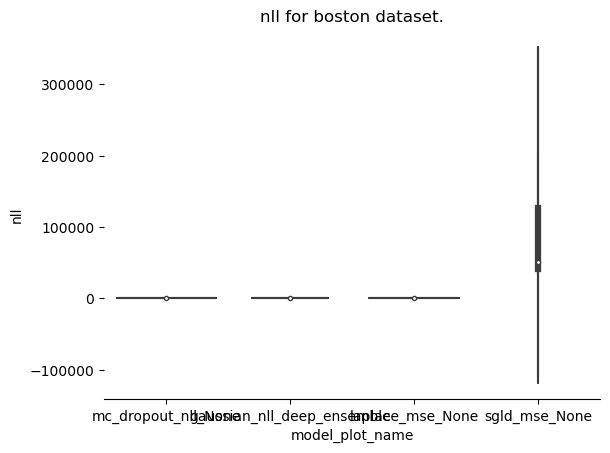

In [20]:
def evaluate_all_models_one_ds(
    dataset_name: str, metric: str, df: pd.DataFrame
) -> None:
    """Evaluate all models on a single dataset.

    Args:
        dataset_name: name of dataset for which to plot results
        metric: name of the metric to visualize

    """
    dataset_df = df[df["dataset_name"] == dataset_name]
    dataset_df = dataset_df.drop_duplicates(
        ["base_model", "loss_fn", "ensemble", "seed"]
    ).reset_index(drop=True)
    dataset_df["model_plot_name"] = (
        dataset_df["base_model"]
        + "_"
        + dataset_df["loss_fn"]
        + "_"
        + dataset_df["ensemble"]
    )

    sns.violinplot(data=dataset_df, x="model_plot_name", y=metric)
    sns.despine(left=True)
    plt.title(f"{metric} for {dataset_name} dataset.")


evaluate_all_models_one_ds("energy", "nll", df)

# Evaluate a single model across datasets

This might be useful to check indidivual model performance and see what is going on.

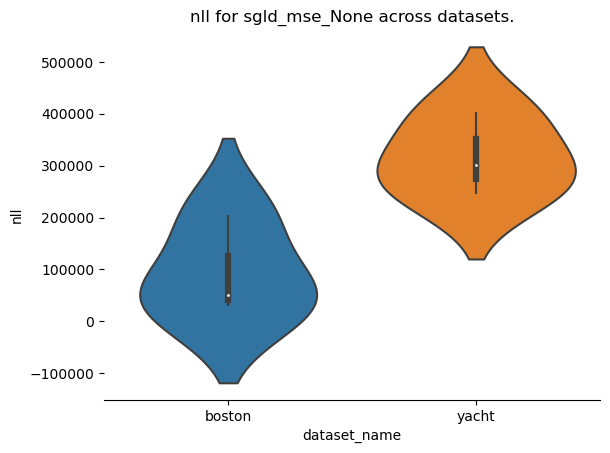

In [21]:
def evaluate_all_models_one_ds(model_name: str, metric: str, df: pd.DataFrame) -> None:
    """Evaluate all models on a single dataset.

    Args:
        dataset_name: name of dataset for which to plot results
        metric: name of the metric to visualize

    """
    dataset_df = df[df["model_plot_name"] == model_name]
    dataset_df = dataset_df.drop_duplicates(
        ["base_model", "loss_fn", "ensemble", "seed", "dataset_name"]
    ).reset_index(drop=True)

    sns.violinplot(data=dataset_df, x="dataset_name", y=metric)
    sns.despine(left=True)
    plt.title(f"{metric} for {model_name} across datasets.")


evaluate_all_models_one_ds("gaussian_nll_None", "nll", df)

# Big Tables with numbers

Here we can autogenerate summary table for different things and also convert them to latex.

In [10]:
df["pred_log_dir"][30]

'experiments/experiments/test_sgd_gaussian_04-03-2023_12-53-10/seed_1'

In [11]:
# TODO code here
df.select_dtypes(include=[np.number])
metric_columns = [
    "nll",
    "crps",
    "check",
    "interval",
    "rms_cal",
    "ma_cal",
    "miscal_area",
    "sharp",
    "mae",
    "rmse",
    "mdae",
    "marpd",
    "r2",
    "corr",
]
other_cols = list(set(df.columns) - set(metric_columns))

mean_df = df.groupby("pred_log_dir")[metric_columns].mean().reset_index()
std_df = df.groupby("pred_log_dir")[metric_columns].std().reset_index()
result_df = pd.merge(
    left=mean_df,
    right=std_df,
    how="left",
    left_on="pred_log_dir",
    right_on="pred_log_dir",
    suffixes=("_mean", "_std"),
)
result_df = pd.merge(
    left=result_df,
    right=df[other_cols].drop_duplicates(subset=["pred_log_dir"], keep="first"),
    how="left",
    left_on="pred_log_dir",
    right_on="pred_log_dir",
)

result_df

,pred_log_dir,nll_mean,crps_mean,check_mean,interval_mean,rms_cal_mean,ma_cal_mean,miscal_area_mean,sharp_mean,mae_mean,...,dataset_name,ensemble,mlp_n_outputs,model_plot_name,date,base_model,ensemble_members,seed,loss_fn,conformalized
0,experiments/experiments/test_sgd_gaussian_03-2...,0.702815,0.269742,0.135993,1.633063,0.052603,0.043077,0.043265,0.335649,0.352868,...,boston,None,2,gaussian_nll_None,2023-03-28 11:06:32,gaussian,1,8,nll,False
1,experiments/experiments/test_sgd_gaussian_04-0...,-0.221096,0.108216,0.054635,0.539148,0.124713,0.109079,0.110123,0.220033,0.153121,...,energy,None,2,gaussian_nll_None,2023-04-03 12:04:22,gaussian,1,4,nll,False
2,experiments/experiments/test_sgd_gaussian_04-0...,0.444093,0.217685,0.109914,1.104776,0.031181,0.024443,0.024425,0.411984,0.306982,...,concrete,None,2,gaussian_nll_None,2023-04-03 12:26:46,gaussian,1,4,nll,False
3,experiments/experiments/test_sgd_gaussian_04-0...,-0.287028,0.110956,0.056020,0.650808,0.253197,0.217061,0.219108,0.366237,0.111696,...,yacht,None,2,gaussian_nll_None,2023-04-03 12:53:10,gaussian,1,1,nll,False
4,experiments/experiments/test_sgd_gaussian_04-1...,1.426669,0.588763,0.297304,2.701149,0.084562,0.074488,0.075160,1.000115,0.876777,...,naval,None,2,gaussian_nll_None,2023-04-12 14:18:17,gaussian,1,4,nll,False


# Create pretty table

In comparision to the results reported in the Subspace Inference paper, "nll" corresponds to (-1)*"normalized test loglikelihood" and "rmse" corresponds to "normalized test rmse".

In [12]:
metrics_to_show = ["nll", "rmse"]

dataset_names = result_df["dataset_name"].unique()
model_names = result_df["model_plot_name"].unique()

for metric in metrics_to_show:
    plot_df = result_df.copy()
    plot_df["metric"] = (
        plot_df[metric + "_mean"].round(4).astype(str)
        + " ("
        + plot_df[metric + "_std"].round(4).astype(str)
        + ")"
    )
    plot_df = plot_df.pivot(
        index="dataset_name", columns="model_plot_name", values="metric"
    )
    plot_df.columns.rename(metric, inplace=True)
    print(plot_df)
    print("")

nll          gaussian_nll_None
dataset_name                  
boston         0.7028 (0.0436)
concrete       0.4441 (0.0138)
energy         -0.2211 (0.632)
naval             1.4267 (0.0)
yacht          -0.287 (0.8775)

rmse         gaussian_nll_None
dataset_name                  
boston         0.6557 (0.0089)
concrete        0.4055 (0.002)
energy         0.2151 (0.0301)
naval             1.0077 (0.0)
yacht          0.1614 (0.0583)

